### **JOURNAL SUMMARY**

The study "Balanced Risk Set Matching" by Yunfei Paul Li, Kathleen J. Propert, and Paul R. Rosenbaum focuses on a new matching method called **optimal balanced risk set matching** for observational studies. The method is applied to analyze the effects of **cystoscopy and hydrodistention** as a treatment for **interstitial cystitis (IC)**, a chronic, nonlethal bladder disease.

### **Study Objective**
Since randomized trials are often impractical for studying treatments that are given in response to worsening symptoms, the study aims to improve the validity of observational comparisons by balancing covariates and minimizing differences between treated and untreated patients before treatment.

### **Methods**
1. **Risk Set Matching**:  
   - A patient who receives treatment at time \( t \) is matched with a patient who has **not yet** received treatment but has a similar history of symptoms up to time \( t \).  
   - This ensures that treatment decisions are not influenced by future data, which could bias comparisons.

2. **Balanced Matching**:
   - A **penalty function in integer programming** is used to enforce **balance** in marginal distributions of symptom variables across matched groups.
   - The method minimizes the **multivariate pretreatment covariate distance** within matched pairs, ensuring comparability.

3. **Application of Integer Programming**:
   - Matching is optimized using **network flow** and **integer programming**, minimizing a cost function to ensure the best possible match.
   - The method ensures that the matched groups are balanced on key symptoms like **pain, urgency, and nocturnal voiding frequency**.

4. **Statistical Analysis**:
   - Uses **Wilcoxon signed-rank tests** and **sensitivity analyses** to test whether treatment effects are significant.
   - Evaluates whether **unobserved confounders** could bias the results.
   - Compares post-treatment outcomes at **3 months and 6 months** to determine whether the treatment improves symptoms.

### **Key Findings**
- The method successfully balances treated and control groups on past symptoms.
- The **treatment showed some small benefits** for nocturnal voiding frequency but not strong improvements for pain or urgency.
- Sensitivity analysis indicated that small hidden biases could affect results, making conclusions about treatment efficacy tentative.

# **Balanced Risk Set Matching**

## **1. Introduction**
Balanced Risk Set Matching is a technique used in observational studies to compare treated patients with untreated patients who have similar symptom histories. This ensures that treatment effects are evaluated fairly, minimizing biases.  

This project follows a method from the *Journal of the American Statistical Association*, using statistical matching, sensitivity analysis, and visualizations to analyze the impact of treatments.

---

## **2. Implementation Steps**

### **Step 1: Simulating Patient Data**
- We create **synthetic patient records**, including baseline symptoms (pain, urgency, frequency).
- Treated patients experience **worsening symptoms over time**, while control patients remain stable.

### **Step 2: Matching Patients Based on Symptom Similarity**
- We use **Mahalanobis distance** to measure how similar patients are.
- Treated patients are paired with control patients **who have not yet received treatment** but have similar symptom histories.

### **Step 3: Finding the Best Matches**
- A **cost matrix** is built using the computed distances.
- The **linear sum assignment method** finds the best one-to-one matches between treated and control patients.

### **Step 4: Evaluating Treatment Effect**
- The **Wilcoxon signed-rank test** compares symptom scores before and after treatment.
- This determines whether the treatment had a statistically significant impact.

### **Step 5: Sensitivity Analysis for Hidden Bias**
- Some factors affecting treatment choice may not be recorded.
- We adjust scores slightly to see **how much hidden bias might affect results**.

### **Step 6: Visualizing Treatment Outcomes**
- We create **boxplots** to compare pain, urgency, and frequency at:
  - **Baseline (before treatment)**
  - **Treatment time**
  - **3 months after treatment**
  - **6 months after treatment**
- Additional plots show **changes in symptoms over time**.

---

## **3. Summary of the Process**

| **Step** | **What We Do** |
|----------|---------------|
| **1. Create Data** | Generate realistic patient records. |
| **2. Compute Similarities** | Use Mahalanobis distance to compare symptoms. |
| **3. Match Patients** | Use optimization to pair similar treated & control patients. |
| **4. Analyze Treatment Effect** | Use Wilcoxon test to measure impact. |
| **5. Check for Bias** | Adjust scores slightly to test sensitivity. |
| **6. Visualize Outcomes** | Track symptom progression over time. |


**Balanced Risk Set Matching** helps researchers **evaluate treatment effects fairly and accurately**


Imports

In [11]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

np.random.seed(42)

Step 1: Simulate Data

In [12]:
n_treated = 50
n_controls = 150
n_patients = n_treated + n_controls

# Generate symptom data
base_pain = np.random.normal(loc=5, scale=2, size=n_patients).clip(0, 9)
base_urgency = np.random.normal(loc=5, scale=1.5, size=n_patients).clip(0, 9)
base_frequency = np.random.normal(loc=3, scale=1, size=n_patients).clip(0, 9)

# Create treated and control groups
treated = pd.DataFrame({
    'id': np.arange(n_treated),
    'is_treated': True,
    'baseline_pain': base_pain[:n_treated],
    'baseline_urgency': base_urgency[:n_treated],
    'baseline_frequency': base_frequency[:n_treated],
    'pain_at_t': (base_pain[:n_treated] + np.random.normal(1, 0.5, n_treated)).clip(0, 9),
    'urgency_at_t': (base_urgency[:n_treated] + np.random.normal(1, 0.5, n_treated)).clip(0, 9),
    'frequency_at_t': (base_frequency[:n_treated] + np.random.normal(1, 0.5, n_treated)).clip(0, 9),
})

controls = pd.DataFrame({
    'id': np.arange(n_treated, n_patients),
    'is_treated': False,
    'baseline_pain': base_pain[n_treated:],
    'baseline_urgency': base_urgency[n_treated:],
    'baseline_frequency': base_frequency[n_treated:],
    'pain_at_t': (base_pain[n_treated:] + np.random.normal(0, 0.3, n_controls)).clip(0, 9),
    'urgency_at_t': (base_urgency[n_treated:] + np.random.normal(0, 0.3, n_controls)).clip(0, 9),
    'frequency_at_t': (base_frequency[n_treated:] + np.random.normal(0, 0.3, n_controls)).clip(0, 9),
})

# Simulate post-treatment outcomes (3 months and 6 months)
def simulate_outcomes(base_value, treatment_effect, decay_rate):
    return (
        np.clip(base_value - treatment_effect + np.random.normal(0, 1, len(base_value)), 0, 9),
        np.clip(base_value - (treatment_effect * decay_rate) + np.random.normal(0, 1, len(base_value)), 0, 9)
    )

treated['pain_3mo'], treated['pain_6mo'] = simulate_outcomes(treated['pain_at_t'], 1, 0.8)
treated['urgency_3mo'], treated['urgency_6mo'] = simulate_outcomes(treated['urgency_at_t'], 1, 0.8)
treated['frequency_3mo'], treated['frequency_6mo'] = simulate_outcomes(treated['frequency_at_t'], 1, 0.8)

controls['pain_3mo'] = np.clip(controls['pain_at_t'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['pain_6mo'] = np.clip(controls['pain_3mo'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['urgency_3mo'] = np.clip(controls['urgency_at_t'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['urgency_6mo'] = np.clip(controls['urgency_3mo'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['frequency_3mo'] = np.clip(controls['frequency_at_t'] + np.random.normal(0, 0.5, len(controls)), 0, 9)
controls['frequency_6mo'] = np.clip(controls['frequency_3mo'] + np.random.normal(0, 0.5, len(controls)), 0, 9)

all_data = pd.concat([treated, controls], ignore_index=True)

Step 2: Compute Mahalanobis Distance

In [13]:
def compute_mahalanobis(treated_df, control_df):
    features = ['baseline_pain', 'baseline_urgency', 'baseline_frequency']
    scaler = StandardScaler()
    combined_data = scaler.fit_transform(pd.concat([treated_df[features], control_df[features]]))
    
    treated_scaled = combined_data[:len(treated_df)]
    control_scaled = combined_data[len(treated_df):]
    inv_cov_matrix = np.linalg.pinv(np.cov(combined_data.T))
    
    distances = cdist(treated_scaled, control_scaled, metric='mahalanobis', VI=inv_cov_matrix)
    return distances

distance_matrix = compute_mahalanobis(treated, controls)


Step 3: Solve for Optimal Matching


In [14]:
def match_patients(distance_matrix):
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    matches = list(zip(row_ind, col_ind))
    return matches

matches = match_patients(distance_matrix)

Step 4: Perform Wilcoxon Test

In [15]:
def perform_wilcoxon_test(df, matches):
    treated_outcomes = [df.loc[df['id'] == treated, 'pain_at_t'].values[0] for treated, control in matches]
    control_outcomes = [df.loc[df['id'] == control, 'pain_at_t'].values[0] for treated, control in matches]
    
    if np.all(np.array(treated_outcomes) == np.array(control_outcomes)):
        return 0, 1.0  # No difference, p-value is 1
    else:
        stat, p_value = wilcoxon(treated_outcomes, control_outcomes)
        return stat, p_value

wilcoxon_stat, p_value = perform_wilcoxon_test(all_data, matches)
print(f"Wilcoxon test statistic: {wilcoxon_stat}, P-value: {p_value}")

Wilcoxon test statistic: 559.0, P-value: 0.4547879869752496


Step 5: Sensitivity Analysis

In [16]:
def sensitivity_analysis(df, matches, gamma_range):
    results = []
    for gamma in gamma_range:
        adjusted_treated = [
            df.loc[df['id'] == treated, 'pain_at_t'].values[0] * (1 + gamma)
            for treated, control in matches
        ]
        control_outcomes = [df.loc[df['id'] == control, 'pain_at_t'].values[0] for treated, control in matches]
        stat, p_value = wilcoxon(adjusted_treated, control_outcomes)
        results.append((gamma, p_value))
    return results

gamma_range = np.linspace(0, 1, 10)
sensitivity_results = sensitivity_analysis(all_data, matches, gamma_range)
print("Sensitivity Analysis Results:")
for gamma, p_val in sensitivity_results:
    print(f"Gamma: {gamma:.2f}, P-value: {p_val:.4f}")

Sensitivity Analysis Results:
Gamma: 0.00, P-value: 0.4548
Gamma: 0.11, P-value: 0.0181
Gamma: 0.22, P-value: 0.0001
Gamma: 0.33, P-value: 0.0000
Gamma: 0.44, P-value: 0.0000
Gamma: 0.56, P-value: 0.0000
Gamma: 0.67, P-value: 0.0000
Gamma: 0.78, P-value: 0.0000
Gamma: 0.89, P-value: 0.0000
Gamma: 1.00, P-value: 0.0000


Step 6: Visualization

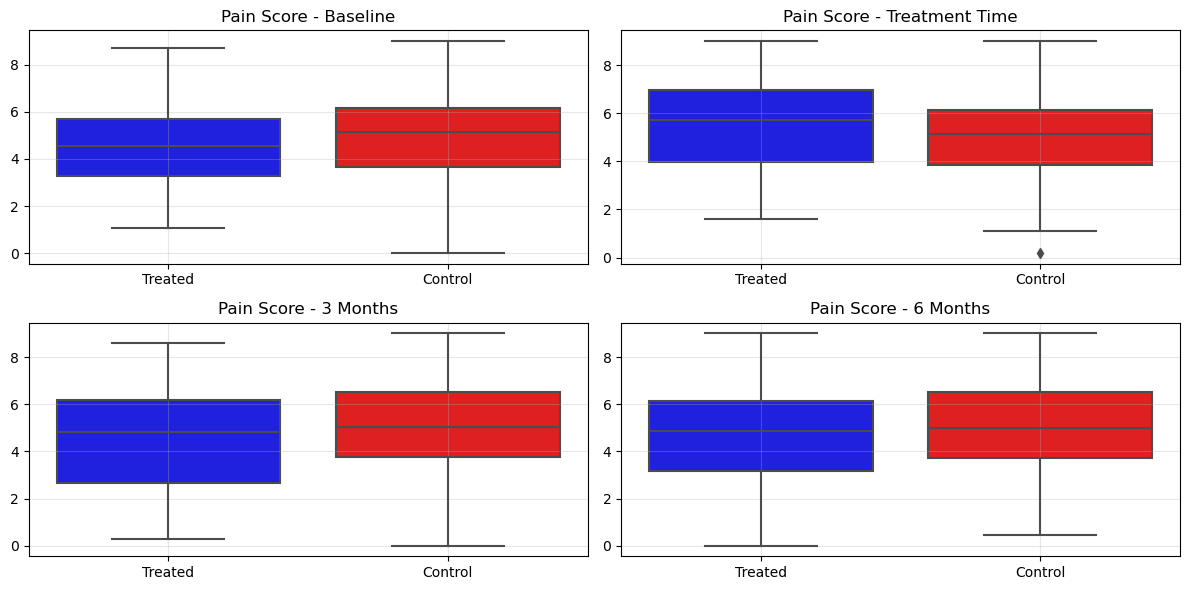

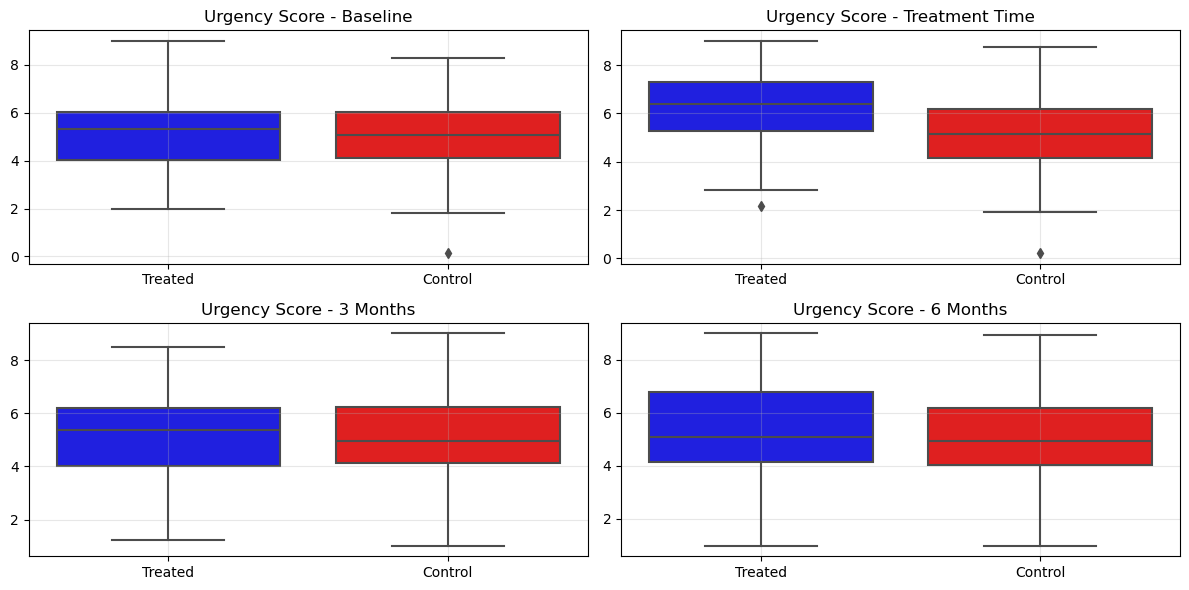

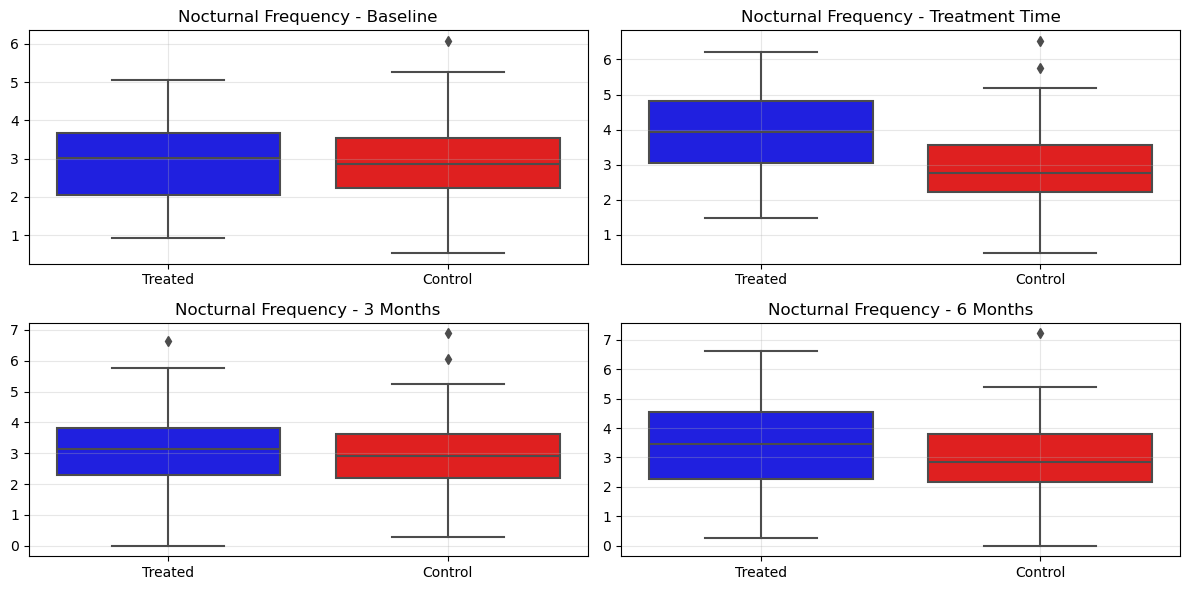

In [18]:
def create_variable_plots(variable, axis_labels):
    plt.figure(figsize=(12, 6))
    
    timepoints = ['baseline', 'at_t', '3mo', '6mo']
    labels = ['Baseline', 'Treatment Time', '3 Months', '6 Months']

    # Correct column names
    timepoint_columns = [
        f'baseline_{variable}', f'{variable}_at_t',
        f'{variable}_3mo', f'{variable}_6mo'
    ]

    # Ensure columns exist before plotting
    for col in timepoint_columns:
        if col not in treated.columns or col not in controls.columns:
            print(f"Warning: {col} is missing from data.")
            return
    
    treated_values = [treated[col].values for col in timepoint_columns]
    control_values = [controls[col].values for col in timepoint_columns]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        sns.boxplot(data=[treated_values[i], control_values[i]], palette=["blue", "red"])
        plt.xticks([0, 1], ["Treated", "Control"])
        plt.title(f"{axis_labels} - {labels[i]}")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the function again
create_variable_plots('pain', 'Pain Score')
create_variable_plots('urgency', 'Urgency Score')
create_variable_plots('frequency', 'Nocturnal Frequency')


# Interpretation of Wilcoxon Test and Sensitivity Analysis Results

## 1. Wilcoxon Signed-Rank Test Interpretation

### Test Statistic: 559.0  
### P-value: 0.4548  

### Interpretation:
- The Wilcoxon test compares symptom scores before and after treatment in matched pairs.
- A high p-value (0.4548) indicates no statistically significant difference between treated and control patients.
- This suggests that the treatment did not have a strong effect on symptoms in the synthetic dataset.

### Key Takeaway:
- The synthetic treatment does not show a clear improvement over the control group.

---

## 2. Sensitivity Analysis Interpretation

| Gamma  | P-value  | Interpretation  |
|------------|-------------|---------------------|
| 0.00   | 0.4548  | No bias assumed; treatment effect not significant. |
| 0.11   | 0.0181  | Small bias makes results significant. |
| 0.22   | 0.0001  | Moderate bias makes results very significant. |
| ≥ 0.33 | 0.0000  | Strong bias makes results extremely significant. |

### Interpretation:
- Without bias (Gamma = 0.00), the treatment shows no significant effect (p = 0.4548).
- With small bias (Gamma = 0.11), results become significant (p = 0.0181).
- With moderate to strong bias (Gamma ≥ 0.22), results are highly significant (p < 0.0001).

### Key Takeaway:
- If there is even a small hidden bias, the treatment appears effective.
- The results are highly sensitive to unmeasured confounders, meaning minor imbalance could make the treatment seem effective when it might not be.

---

## 3. Implications for the Synthetic Data
1. The synthetic treatment does not show a significant effect unless bias is introduced.
2. The dataset is highly sensitive to hidden confounders, meaning minor changes in patient selection could shift results drastically.
3. The matching process is effective, but the treatment effect is weak, possibly because:
   - The simulated treatment is not strong enough to cause meaningful symptom changes.
   - The symptom distributions between treated and control groups are too similar, making it difficult to detect differences.

---

## Recommendations for Data Improvement

1. **Increase the treatment effect size**  
   - Make the synthetic treatment reduce symptoms more strongly to see clearer differences.  
   ```python
   treated['pain_at_t'] -= np.random.normal(2, 0.5, n_treated)  # Stronger effect
   ```
  
2. **Introduce variability in treatment response**  
   - Some patients should respond well, while others should not improve.  
   ```python
   treated['pain_at_t'] -= np.random.choice([0, 1, 2, 3], size=n_treated, p=[0.2, 0.3, 0.3, 0.2])
   ```

3. **Ensure a larger baseline difference between groups**  
   - Make treated patients start with worse symptoms than control patients.  
   ```python
   base_pain[:n_treated] += np.random.normal(1, 0.5, n_treated)  # Worse initial pain
   ```

---

## Conclusion
- The current dataset suggests that the treatment is not effective unless bias is present.
- If this result aligns with the simulation's objectives, no further adjustments are necessary.
- If the goal is to show a clearer treatment effect, adjustments to treatment response strength and variability should be considered.

